## One-Dimensional Steady Flow with Transport

phreeqc ex11



### One-Dimensional Steady Flow with Transport Problem Setup

Imports

In [1]:
import os
import sys

In [2]:
import flopy
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import modflowapi
from modflowapi import Callbacks
from pathlib import Path

In [4]:
import phreeqcrm
import shutil

In [5]:
# testing
import inspect
from pathlib import Path

module_path = Path(inspect.getframeinfo(inspect.currentframe()).filename).resolve()
print(sys.path[0])

C:\Users\charlton\source\repos\coupled\modflow6-examples\notebooks


Append to system path to include the common subdirectory

In [6]:
sys.path.append(os.path.join("..", "common"))

Import common functionality

In [7]:
import analytical
import config
from figspecs import USGSFigure

Set figure properties specific to this problem

In [8]:
figure_size = (5, 3)

Base simulation and model name and workspace

In [9]:
ws = config.base_ws
example_name = "moc"

In [10]:
from contextlib import contextmanager
@contextmanager
def change_directory(new_dir):
    original_dir = os.getcwd()  # Get the current working directory

    # Convert relative path to an absolute path
    new_dir = os.path.abspath(new_dir)
    
    # Check if the directory exists; if not, create it
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    try:
        os.chdir(new_dir)  # Change to the specified directory
        yield
    finally:
        os.chdir(original_dir)  # Change back to the original directory when done

Scenario parameters - make sure there is at least one blank line before next item

In [11]:
parameters = {
    "ex11": {
        "longitudinal_dispersivity": 0.0,
        "retardation_factor": 1.0,
        "decay_rate": 0.0,
#        "solutes":                ['Na', 'Cl', 'K', 'Ca', 'N(5)'],
#        "initial_solution":       [ 1.0,  0.0, 0.2,  0.0,  1.2  ],   # mmol/kgw
#        "influent_concentration": [ 0.0,  1.2, 0.0,  0.6,  0.0  ],   # mmol/kgw
    },
}

Scenario parameter units - make sure there is at least one blank line before next item
add parameter_units to add units to the scenario parameter table

In [12]:
parameter_units = {
    "longitudinal_dispersivity": "$m$",
    "retardation_factor": "unitless",
    "decay_rate": "$s^{-1}$",
}

Model units

In [13]:
length_units = "METERS"    # m
time_units = "seconds"     # s

Table of model parameters

In [14]:
nper = 1                      # Number of periods
nlay = 1                      # Number of layers
nrow = 1                      # Number of rows
ncol = 40                     # Number of columns
system_length = .08           # Length of system ($m$)
delr = 0.002                  # Column width ($m$)
delc = 1.0                    # Row width ($m$)
top = 1.0                     # Top of the model ($m$)
botm = 0                      # Layer bottom elevation ($m$)
specific_discharge = 1./720.  # Specific discharge ($m s^{-1}$)
hydraulic_conductivity = 1.0  # Hydraulic conductivity ($m s^{-1}$)
porosity = 1.0                # Porosity of mobile domain (unitless)
total_time = 14400.0          # Simulation time ($s$)

Create yaml for phreeqcrm initialize()

In [15]:
def setup_phreeqcrm(sim_folder):
    
    ##os.chdir(sys.path[0])
    notebook_directory = sys.path[0]    
    assert(os.getcwd() == notebook_directory)

    assert(sim_folder == "ex11")
    
    # get abspath before change_directory
    sim_ws = os.path.abspath(os.path.join(ws, sim_folder, "phreeqcrm"))

    with change_directory(sim_ws):
        
        # copy phreeqc.dat to sim_ws
        source_file = os.path.join(notebook_directory, 'phreeqc.dat')
        shutil.copy(source_file, sim_ws)

        # copy advect.pqi to sim_ws
        source_file = os.path.join(notebook_directory, 'advect.pqi')
        shutil.copy(source_file, sim_ws)
    
        # Create YAMLPhreeqcRM document
        yrm = phreeqcrm.YAMLPhreeqcRM()

        # Number of cells
        nxyz = 40
        assert(nxyz == nlay*nrow*ncol)

        # Set GridCellCount
        yrm.YAMLSetGridCellCount(nxyz)

        # Set some properties
        yrm.YAMLSetErrorHandlerMode(1)
        yrm.YAMLSetComponentH2O(False)
        yrm.YAMLSetRebalanceFraction(0.5)
        yrm.YAMLSetRebalanceByCell(True)
        yrm.YAMLUseSolutionDensityVolume(False)
        yrm.YAMLSetPartitionUZSolids(False)

        # Set concentration units
        yrm.YAMLSetUnitsSolution(2)           # 1, mg/L; 2, mol/L; 3, kg/kgs
        yrm.YAMLSetUnitsPPassemblage(1)       # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsExchange(1)           # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsSurface(1)            # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsGasPhase(1)           # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsSSassemblage(1)       # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
        yrm.YAMLSetUnitsKinetics(1)           # 0, mol/L cell; 1, mol/L water; 2 mol/L rock

        # Set conversion from seconds to user units (days) Only affects one print statement
        time_conversion = 1.0 / 86400.0
        yrm.YAMLSetTimeConversion(time_conversion)

        # Set representative volume
        rv = [1] * nxyz
        yrm.YAMLSetRepresentativeVolume(rv)

        # Set initial density
        density = [1.0] * nxyz
        yrm.YAMLSetDensityUser(density)

        # Set initial porosity
        por = [0.2] * nxyz
        yrm.YAMLSetPorosity(por)

        # Set initial saturation
        sat = [1] * nxyz
        yrm.YAMLSetSaturationUser(sat)

        # Load database
        yrm.YAMLLoadDatabase("phreeqc.dat")

        # Run file to define solutions and reactants for initial conditions, selected output
        workers = True             # Worker instances do the reaction calculations for transport
        initial_phreeqc = True     # InitialPhreeqc instance accumulates initial and boundary conditions
        utility = True             # Utility instance is available for processing
        yrm.YAMLRunFile(workers, initial_phreeqc, utility, "advect.pqi")

        # Clear contents of workers and utility
        initial_phreeqc = False
        input = "DELETE; -all"
        yrm.YAMLRunString(workers, initial_phreeqc, utility, input)
        yrm.YAMLAddOutputVars("AddOutputVars", "true")

        # Determine number of components to transport
        yrm.YAMLFindComponents()

        # initial solutions
        initial_solutions = [1] * nxyz
        yrm.YAMLInitialSolutions2Module(initial_solutions)

        # initial exchanges
        initial_exchanges = [1] * nxyz
        yrm.YAMLInitialExchanges2Module(initial_exchanges)

        # Write YAML file
        yrm.WriteYAMLDoc("ex11-advect.yaml")
        
    return "ex11-advect.yaml"

In [16]:
def build_phreeqcrm(sim_folder):
    print(f"sim_folder={sim_folder}")
    yaml = setup_phreeqcrm(sim_folder)
    
    rm = None
    try:
        # get abspath before change_directory
        sim_ws = os.path.abspath(os.path.join(ws, sim_folder, "phreeqcrm"))
        
        rm = phreeqcrm.BMIPhreeqcRM()
        with change_directory(sim_ws):
            rm.initialize(yaml)
            
        rm.solutes = rm.get_value_ptr("Components")
        ncomps = rm.get_value_ptr("ComponentCount")[0]

        nxyz = nlay*nrow*ncol
        assert nxyz == rm.get_value_ptr("GridCellCount")[0]        
        
        # Get initial concentrations
        rm.initial_solution = rm.get_value_ptr("Concentrations")[::nxyz]
        assert len(rm.initial_solution) == ncomps

        # Set boundary condition
        bc1 = [0]           # solution 0 from Initial IPhreeqc instance
        rm.influent_concentration = rm.InitialPhreeqc2Concentrations(bc1)        

        
        #rm.solutes = rm.solutes[3:]
        #rm.initial_solution = rm.initial_solution[3:]
        #rm.influent_concentration = rm.influent_concentration[3:]
        
        #rm.initial_solution = rm.initial_solution * 1000
        #rm.influent_concentration = rm.influent_concentration * 1000
            
    except:
        raise RuntimeError("build_phreeqcrm failed")
    return rm

### Functions to build, write, run, and plot models

MODFLOW 6 flopy GWF simulation object (sim) is returned


In [17]:
def get_sorption_dict(retardation_factor):
    sorption = None
    bulk_density = None
    distcoef = None
    if retardation_factor > 1.0:
        sorption = "linear"
        bulk_density = 1.0
        distcoef = (retardation_factor - 1.0) * porosity / bulk_density
    sorption_dict = {
        "sorption": sorption,
        "bulk_density": bulk_density,
        "distcoef": distcoef,
    }
    return sorption_dict

In [18]:
def get_decay_dict(decay_rate, sorption=False):
    first_order_decay = None
    decay = None
    decay_sorbed = None
    if decay_rate != 0.0:
        first_order_decay = True
        decay = decay_rate
        if sorption:
            decay_sorbed = decay_rate
    decay_dict = {
        "first_order_decay": first_order_decay,
        "decay": decay,
        "decay_sorbed": decay_sorbed,
    }
    return decay_dict

In [19]:
def build_mf6gwf(sim_folder, solutes, influent_concentration):
    # print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(ws, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(
        sim_name=name, sim_ws=sim_ws, exe_name="mf6"
    )
    tdis_ds = ((total_time, 1, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    wel_spd = {
        0: [
            [
                (0, 0, 0),
                specific_discharge * delc * delr,   # m^3/s
                *influent_concentration,
            ]
        ],
    }
    
    print(f"wel_spd={wel_spd}")
    print(f"solutes={solutes}")
    ###raise RuntimeError("STOP")    
    
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        pname="WEL-1",
        auxiliary=solutes.tolist()
    )
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    
    # set vars for use in run_model
    sim.sim_ws = sim_ws

    return sim

MODFLOW 6 flopy GWF simulation object (sim) is returned

In [20]:
def build_mf6gwt(sim_folder, solute, initial_solution, longitudinal_dispersivity, retardation_factor, decay_rate):
    # print(f"Building mf6gwt_{solute} model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(ws, sim_folder, f"mf6gwt_{solute}")
    sim = flopy.mf6.MFSimulation(
        sim_name=name, sim_ws=sim_ws, exe_name="mf6"
    )
    tdis_ds = ((total_time, 240, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab")
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=initial_solution, filename=f"{name}.ic")
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity,
        **get_sorption_dict(retardation_factor),
        **get_decay_dict(decay_rate, retardation_factor > 1.0),
    )
    flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
    flopy.mf6.ModflowGwtdsp(
        gwt,
        xt3d_off=True,
        alh=longitudinal_dispersivity,
        ath1=longitudinal_dispersivity,
    )
    pd = [
        ("GWFHEAD", f"../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
    sourcerecarray = [["WEL-1", "AUX", solute]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    obs_data = {
        f"{solute}.obs.csv": [
            ("CELL00", "CONCENTRATION", (0, 0, 0)),
            ("CELL01", "CONCENTRATION", (0, 0, 1)),
            ("CELL02", "CONCENTRATION", (0, 0, 2)),
            ("CELL03", "CONCENTRATION", (0, 0, 3)),
            ("CELL04", "CONCENTRATION", (0, 0, 4)),
            ("CELL05", "CONCENTRATION", (0, 0, 5)),
            ("CELL06", "CONCENTRATION", (0, 0, 6)),
            ("CELL07", "CONCENTRATION", (0, 0, 7)),
            ("CELL08", "CONCENTRATION", (0, 0, 8)),
            ("CELL09", "CONCENTRATION", (0, 0, 9)),
            ("CELL10", "CONCENTRATION", (0, 0, 10)),
            ("CELL11", "CONCENTRATION", (0, 0, 11)),
            ("CELL12", "CONCENTRATION", (0, 0, 12)),
            ("CELL13", "CONCENTRATION", (0, 0, 13)),
            ("CELL14", "CONCENTRATION", (0, 0, 14)),
            ("CELL15", "CONCENTRATION", (0, 0, 15)),
            ("CELL16", "CONCENTRATION", (0, 0, 16)),
            ("CELL17", "CONCENTRATION", (0, 0, 17)),
            ("CELL18", "CONCENTRATION", (0, 0, 18)),
            ("CELL19", "CONCENTRATION", (0, 0, 19)),
            ("CELL20", "CONCENTRATION", (0, 0, 20)),
            ("CELL21", "CONCENTRATION", (0, 0, 21)),
            ("CELL22", "CONCENTRATION", (0, 0, 22)),
            ("CELL23", "CONCENTRATION", (0, 0, 23)),
            ("CELL24", "CONCENTRATION", (0, 0, 24)),
            ("CELL25", "CONCENTRATION", (0, 0, 25)),
            ("CELL26", "CONCENTRATION", (0, 0, 26)),
            ("CELL27", "CONCENTRATION", (0, 0, 27)),
            ("CELL28", "CONCENTRATION", (0, 0, 28)),
            ("CELL29", "CONCENTRATION", (0, 0, 29)),
            ("CELL30", "CONCENTRATION", (0, 0, 30)),
            ("CELL31", "CONCENTRATION", (0, 0, 31)),
            ("CELL32", "CONCENTRATION", (0, 0, 32)),
            ("CELL33", "CONCENTRATION", (0, 0, 33)),
            ("CELL34", "CONCENTRATION", (0, 0, 34)),
            ("CELL35", "CONCENTRATION", (0, 0, 35)),
            ("CELL36", "CONCENTRATION", (0, 0, 36)),
            ("CELL37", "CONCENTRATION", (0, 0, 37)),
            ("CELL38", "CONCENTRATION", (0, 0, 38)),
            ("CELL39", "CONCENTRATION", (0, 0, 39)),
        ],
    }
    obs_package = flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, continuous=obs_data
    )
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{name}.cbc",
        concentration_filerecord=f"{name}.ucn",
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    
    # set vars for use in run_model
    sim.sim_ws = sim_ws
    sim.solute = solute
    
    return sim

In [21]:
#def build_model(sim_name, solutes, initial_solution, influent_concentration, longitudinal_dispersivity, retardation_factor, decay_rate):
def build_model(sim_name, longitudinal_dispersivity, retardation_factor, decay_rate):
    sims = None
    if config.buildModel:
        # build_phreeqcrm
        sim_phreeqcrm = build_phreeqcrm(sim_name)
        
        solutes = sim_phreeqcrm.solutes
        
        initial_solution = sim_phreeqcrm.initial_solution

        influent_concentration = sim_phreeqcrm.influent_concentration
        
        print(f"influent_concentration={influent_concentration}")
        ##raise RuntimeError("STOP")
        
        sim_mf6gwf = build_mf6gwf(sim_name, solutes, influent_concentration)
        sims = (sim_phreeqcrm, sim_mf6gwf)
        for i, solute in enumerate(solutes):
            sim_mf6gwt = build_mf6gwt(
                sim_name, solute, initial_solution[i], longitudinal_dispersivity, retardation_factor, decay_rate
                )
            sims = sims + (sim_mf6gwt,)
    return sims

Function to write model files

In [22]:
def write_model(sims, silent=True):
    if config.writeModel:
        _, sim_mf6gwf, *sim_mf6gwts = sims
        sim_mf6gwf.write_simulation(silent=silent)
        for sim_mf6gwt in sim_mf6gwts:
            sim_mf6gwt.write_simulation(silent=silent)
    return

In [23]:
def callback_function(sim, callback_step):
    """
    A demonstration function that dynamically adjusts recharge
    and pumping in a modflow-6 model through the MODFLOW-API
    
    Parameters
    ----------
    sim : modflowapi.ApiSimulation
        A simulation object for the solution group that is 
        currently being solved
    step : enumeration
        modflowapi.Callbacks enumeration object that indicates
        the part of the solution modflow is currently in.
    """
    if callback_step == Callbacks.initialize:
        #print("callback_step == Callbacks.initialize")
        #print(sim)
        pass
    
    if callback_step == Callbacks.stress_period_start:
        #print("callback_step == Callbacks.stress_period_start")
        #print(sim)
        pass
    
    if callback_step == Callbacks.timestep_start:
        #print("callback_step == Callbacks.timestep_start")
        #print(sim)
        pass
        
    if callback_step == Callbacks.iteration_start:
        #print("callback_step == Callbacks.iteration_start")
        #print(sim)
        pass


Function to run the model
True is returned if the model runs successfully

In [24]:
@config.timeit
def run_model_api_bmi(sims, silent=True):
    success = True
    if config.runModel:
        # @todo update for other OSs        
        libmf6 = Path(os.path.join(os.environ["USERPROFILE"], "AppData\\Local\\flopy\\bin", "libmf6"))

        _, sim_mf6gwf, *sim_mf6gwts = sims        
        mf6 = modflowapi.ModflowApi(libmf6, working_directory=sim_mf6gwf.sim_ws)
        mf6.initialize()
        
        current_time = mf6.get_current_time()
        end_time = mf6.get_end_time()
        while current_time < end_time:
            mf6.update()
            current_time = mf6.get_current_time()
        mf6.finalize()
        if not silent:
            print("(mf6gwf) NORMAL TERMINATION OF SIMULATION")
        
        for sim_mf6gwt in sim_mf6gwts:
            mf6 = modflowapi.ModflowApi(libmf6, working_directory=sim_mf6gwt.sim_ws)
            mf6.initialize()
            
            current_time = mf6.get_current_time()
            end_time = mf6.get_end_time()           
            while current_time < end_time:
                mf6.update()
                current_time = mf6.get_current_time()
            mf6.finalize()
            if not silent:
                print(f"(mf6gwt({sim_mf6gwt.solute})) NORMAL TERMINATION OF SIMULATION")
    return success

Function to plot the model results

In [25]:
def plot_results_ct(
    sims, idx, solutes_idx, solutes, longitudinal_dispersivity, retardation_factor, decay_rate
):
    if config.plotModel:
        _, sim_mf6gwf, *sim_mf6gwts = sims
        sim_mf6gwt = sim_mf6gwts[solutes_idx]
        fs = USGSFigure(figure_type="graph", verbose=False)

        sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
        mf6gwt_ra = sim_mf6gwt.get_model("trans").obs.output.obs().data
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        iskip = 5
        
        obsnames = ["CELL00", "CELL19", "CELL39"]
        simtimes = mf6gwt_ra["totim"]
        
        #{
        #print(solutes[solutes_idx])
        #print(simtimes[::iskip])
        #print(mf6gwt_ra[obsnames[0]][::iskip])
        #}
        
        dispersion_coefficient = (
            longitudinal_dispersivity * specific_discharge / retardation_factor
        )
        colors=["blue", "red", "green"]
        for i, x in enumerate([0.05, 4.05, 11.05]):
            axs.plot(
                simtimes[::iskip],
                mf6gwt_ra[obsnames[i]][::iskip],
                marker="o",
                ls="none",
                mec=colors[i],
                mfc="none",
                markersize="4",
                label=obsnames[i],
            )
        ##axs.set_ylim(0, 1.4)
        ##axs.set_xlim(0, 1.2 * total_time)
        axs.set_xlabel("Time (seconds)")
        axs.set_ylabel(f"{solutes[solutes_idx]} Concentration (mol/kgw)")
        axs.legend()

        # save figure
        if config.plotSave:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-ct{config.figure_ext}"
            fpth = os.path.join(ws, "..", "figures", fname)
            fig.savefig(fpth)

In [26]:
def plot_results_cd(
    sims, idx, solutes_idx, solutes, longitudinal_dispersivity, retardation_factor, decay_rate
):
    if config.plotModel:
        #print(f"Plotting {solutes[solutes_idx]} versus x model results...")
        _, sim_mf6gwf, *sim_mf6gwts = sims
        sim_mf6gwt = sim_mf6gwts[solutes_idx]
        fs = USGSFigure(figure_type="graph", verbose=False)
        
        ucnobj_mf6 = sim_mf6gwt.trans.output.concentration()        
        
        ##fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        ##fig, axs = plt.subplots(1, 1, figsize=figure_size)
        fig, axs = plt.subplots(1, 1)
        
        ctimes = [14400.]
        #x = np.linspace(0.5 * delr, system_length - 0.5 * delr, ncol - 1)
        x = np.linspace(0.5 * delr, system_length - 0.5 * delr, ncol)
        dispersion_coefficient = (
            longitudinal_dispersivity * specific_discharge / retardation_factor
        )
        
        colors=["blue", "red", "green"]
        for i, t in enumerate(ctimes):
            simconc = ucnobj_mf6.get_data(totim=t).flatten()
            assert(len(x) == len(simconc))
            #{
            print(x)
            print(simconc)
            #}
            axs.plot(
                x,
                simconc,
                marker="o",
                ls="none",
                mec=colors[i],
                mfc="none",
                markersize="4",
            )
        ##axs.set_ylim(0, 1.4)
        ##axs.set_xlim(0, 1.2 * system_length)
        if idx in [0]:
            axs.text(.070, 0.7, "t=14400 s")
        axs.set_xlabel("Distance (m)")
        axs.set_ylabel(f"{solutes[solutes_idx]} Concentration (mol/kgw)")
        #plt.legend()

        # save figure
        if config.plotSave:
            sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-cd{config.figure_ext}"
            fpth = os.path.join(ws, "..", "figures", fname)
            fig.savefig(fpth)

Function that wraps all of the steps for each scenario

1. build_model,
2. write_model,
3. run_model, and
4. plot_results.


In [27]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    
    sims = build_model(key, **parameter_dict)
    write_model(sims, silent=silent)
    #success = run_model(sims, silent=silent)
    #success = run_model_api_inline_run_simulation(sims, silent=silent)
    #success = run_model_api_run_simulation(sims, silent=silent)
    success = run_model_api_bmi(sims, silent=silent)
    #success = run_model_api_xmi(sims, silent=silent)
    
    if success:
        sim_phreeqcrm, sim_mf6gwf, *sim_mf6gwts = sims
        solutes = sim_phreeqcrm.solutes
        for sidx, solute in enumerate(solutes):
            #if sidx != 0:
            #    continue
            plot_results_ct(sims, idx, sidx, solutes, **parameter_dict)
            #if sidx not in [0, 1]:
                #plot_results_cd(sims, idx, sidx, solutes, **parameter_dict)

In [28]:
def test_01():
    scenario(0, silent=False)

sim_folder=ex11
influent_concentration=[1.10682078e+02 5.53415722e+01 4.24686765e-18 5.98214491e-04
 1.19642898e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
wel_spd={0: [[(0, 0, 0), 2.777777777777778e-06, 110.68207752938942, 55.34157223660389, 4.246867651631757e-18, 0.0005982144914908316, 0.001196428982981659, 0.0, 0.0, 0.0]]}
solutes=['H' 'O' 'Charge' 'Ca' 'Cl' 'K' 'N' 'Na']
run_model_api_bmi  1,591.22 ms


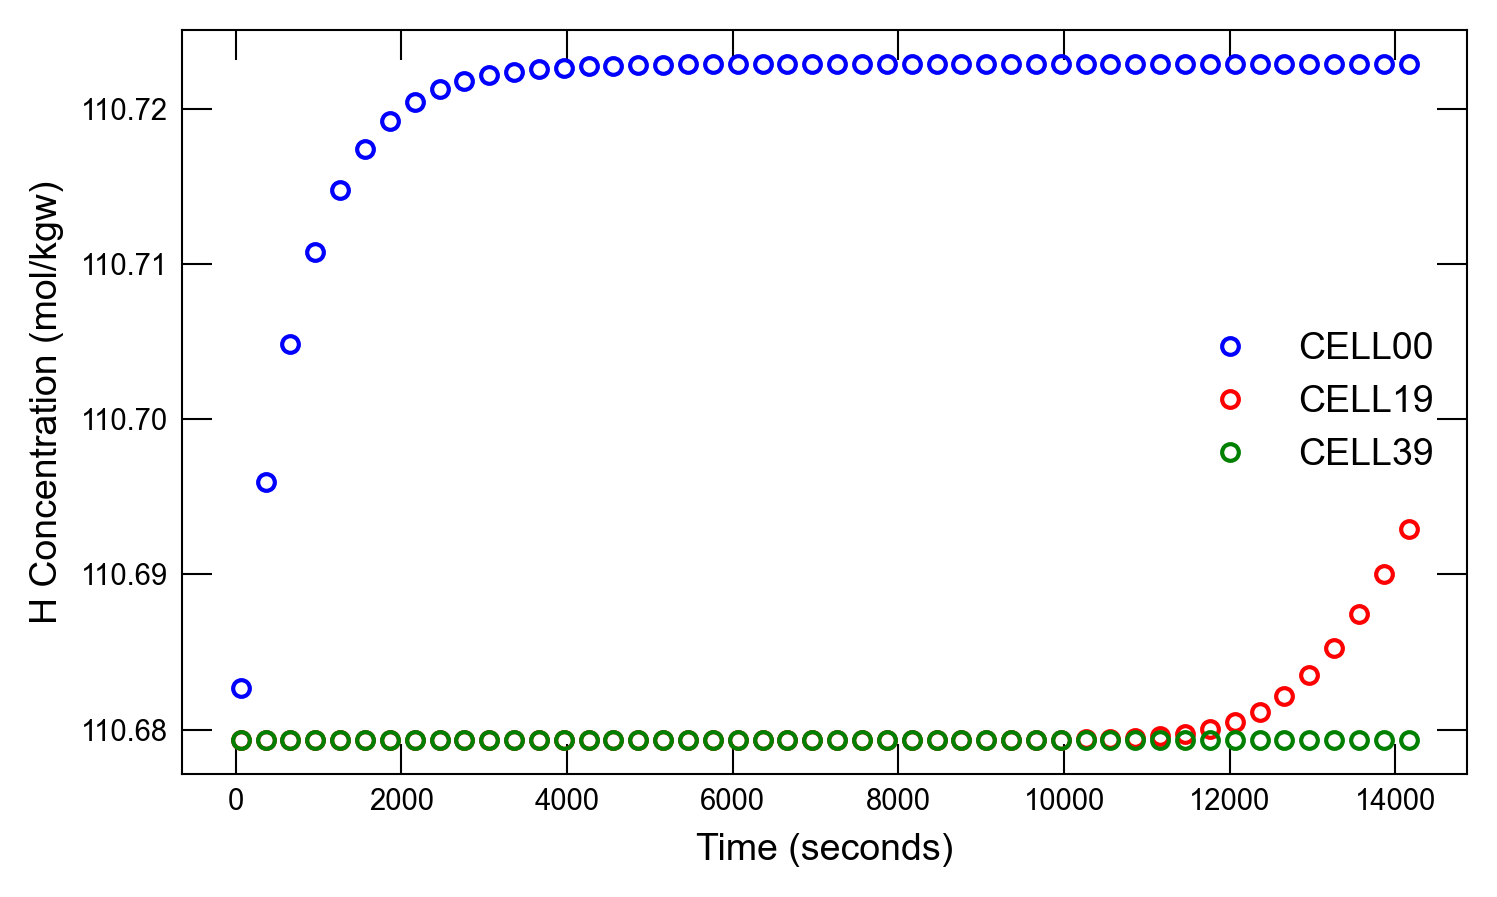

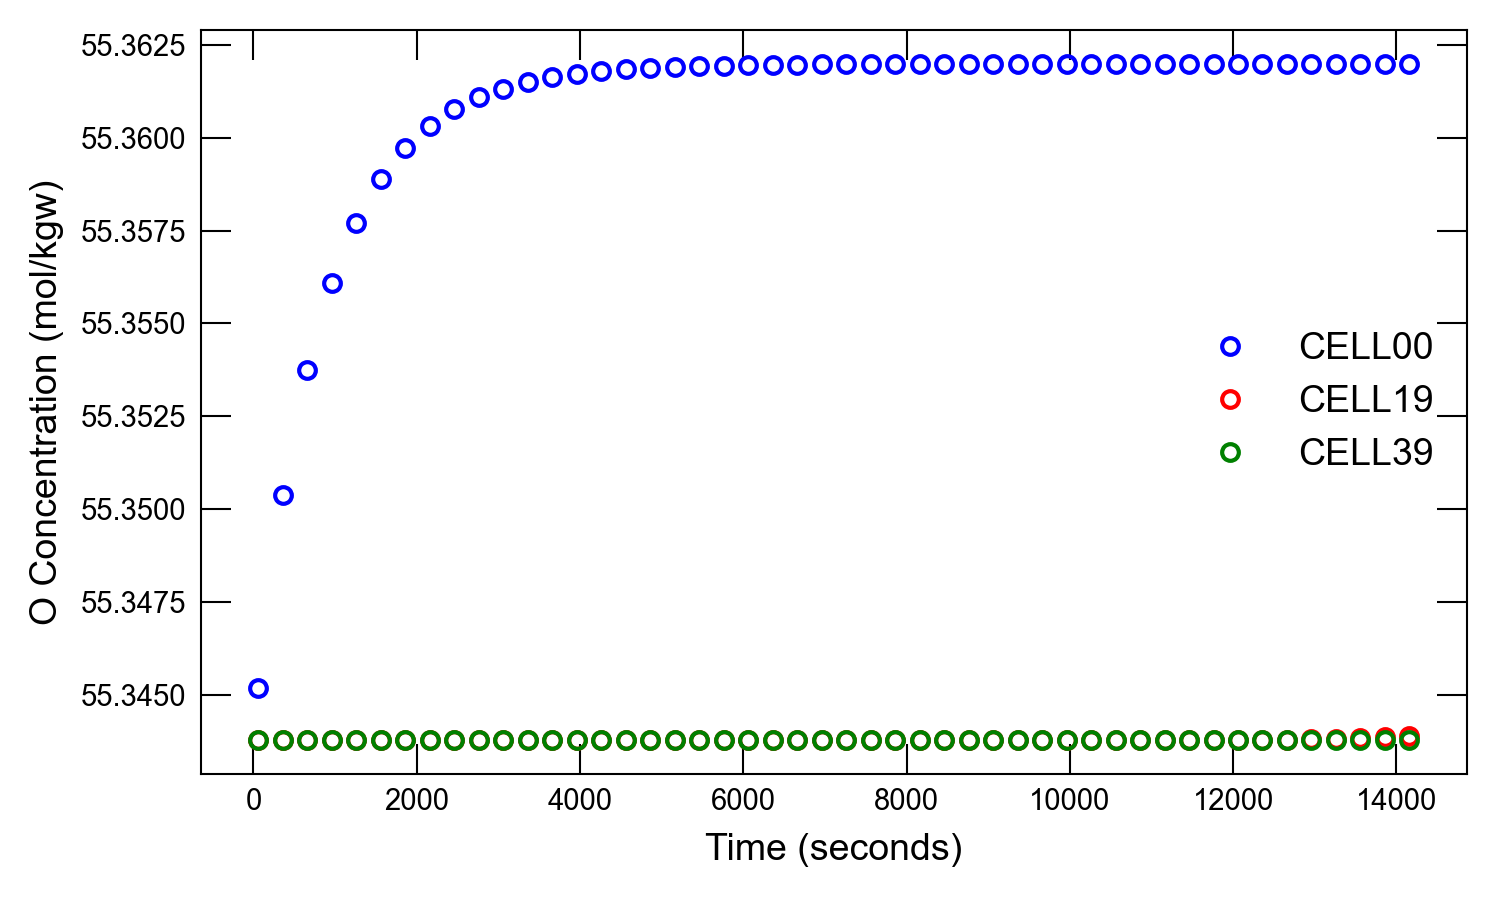

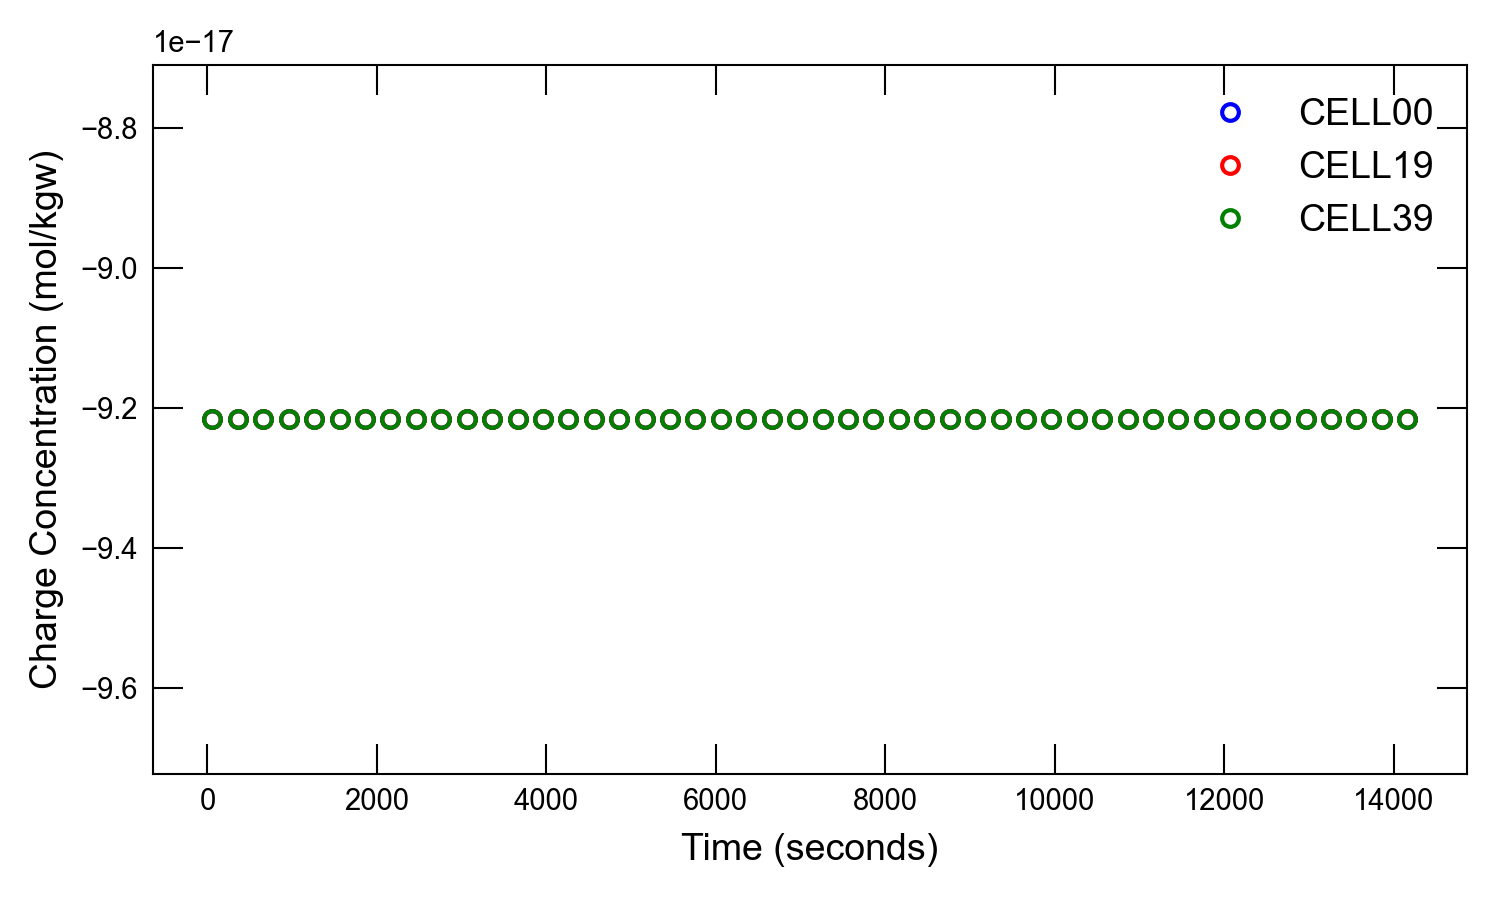

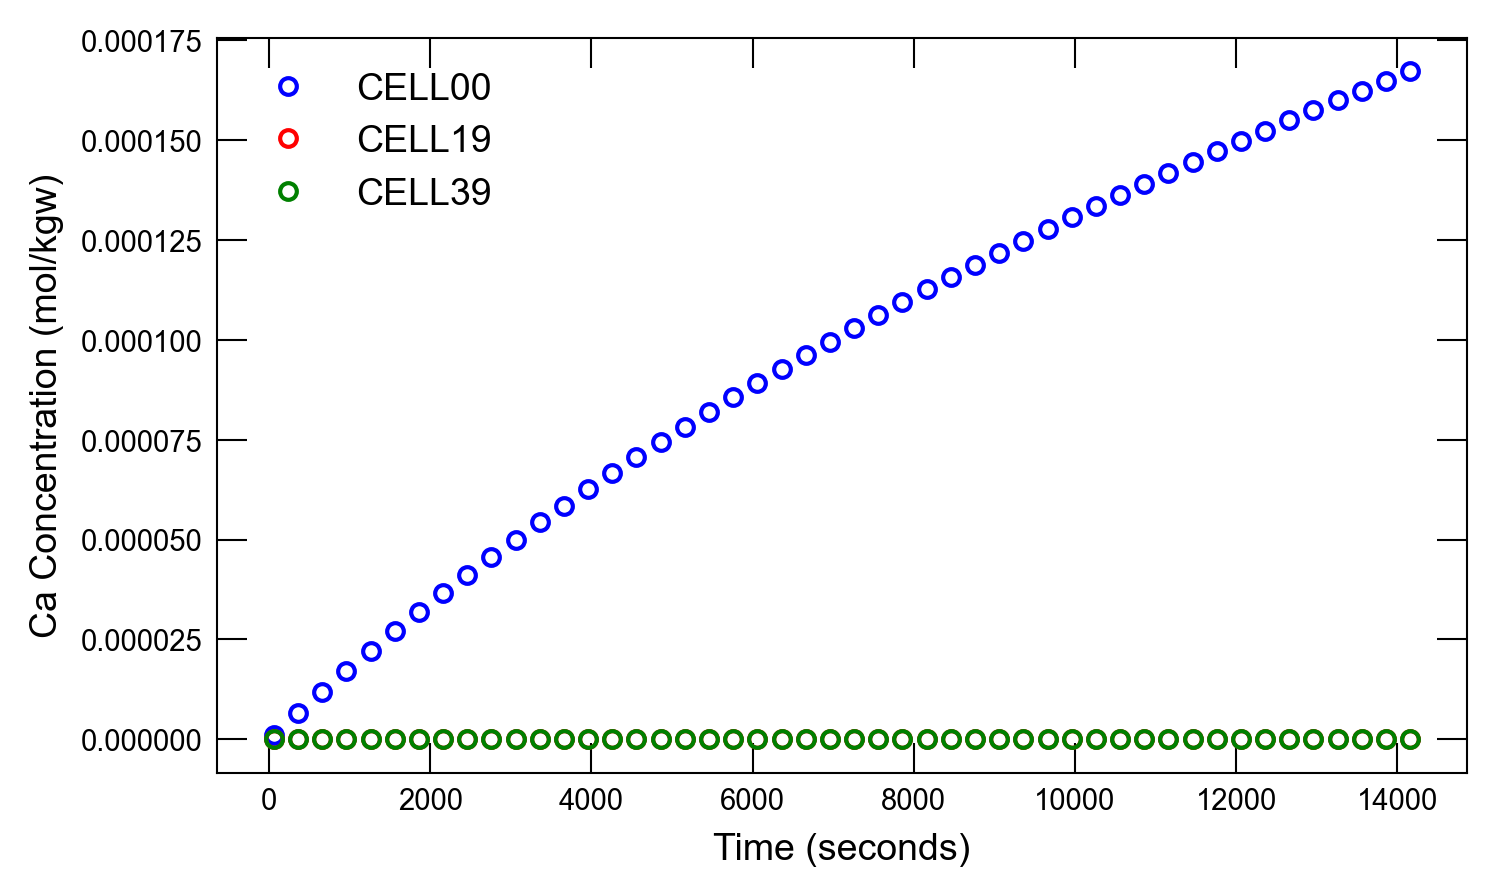

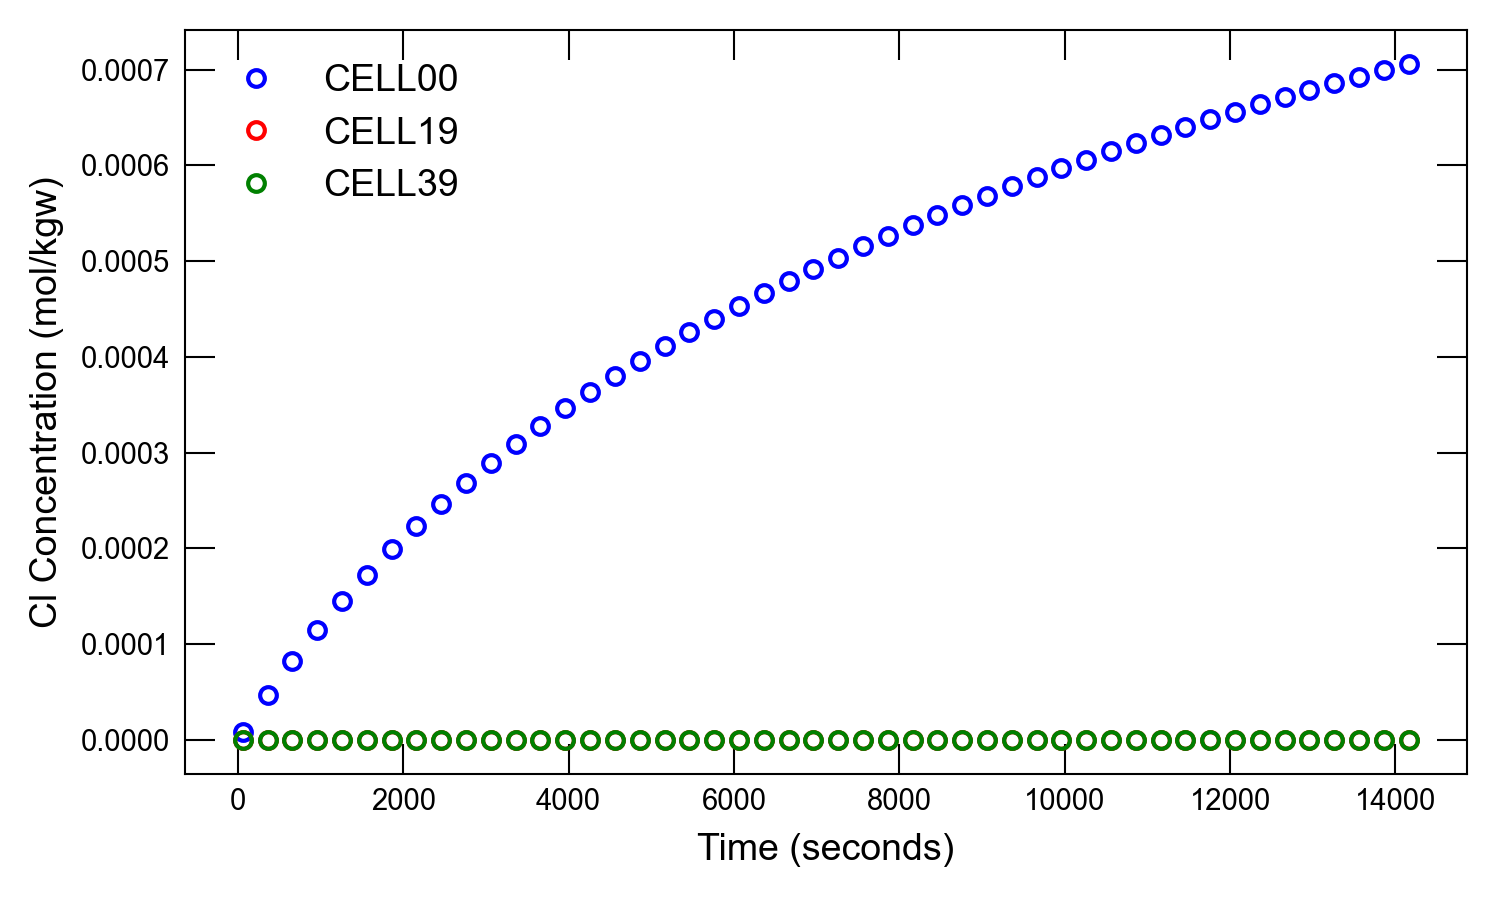

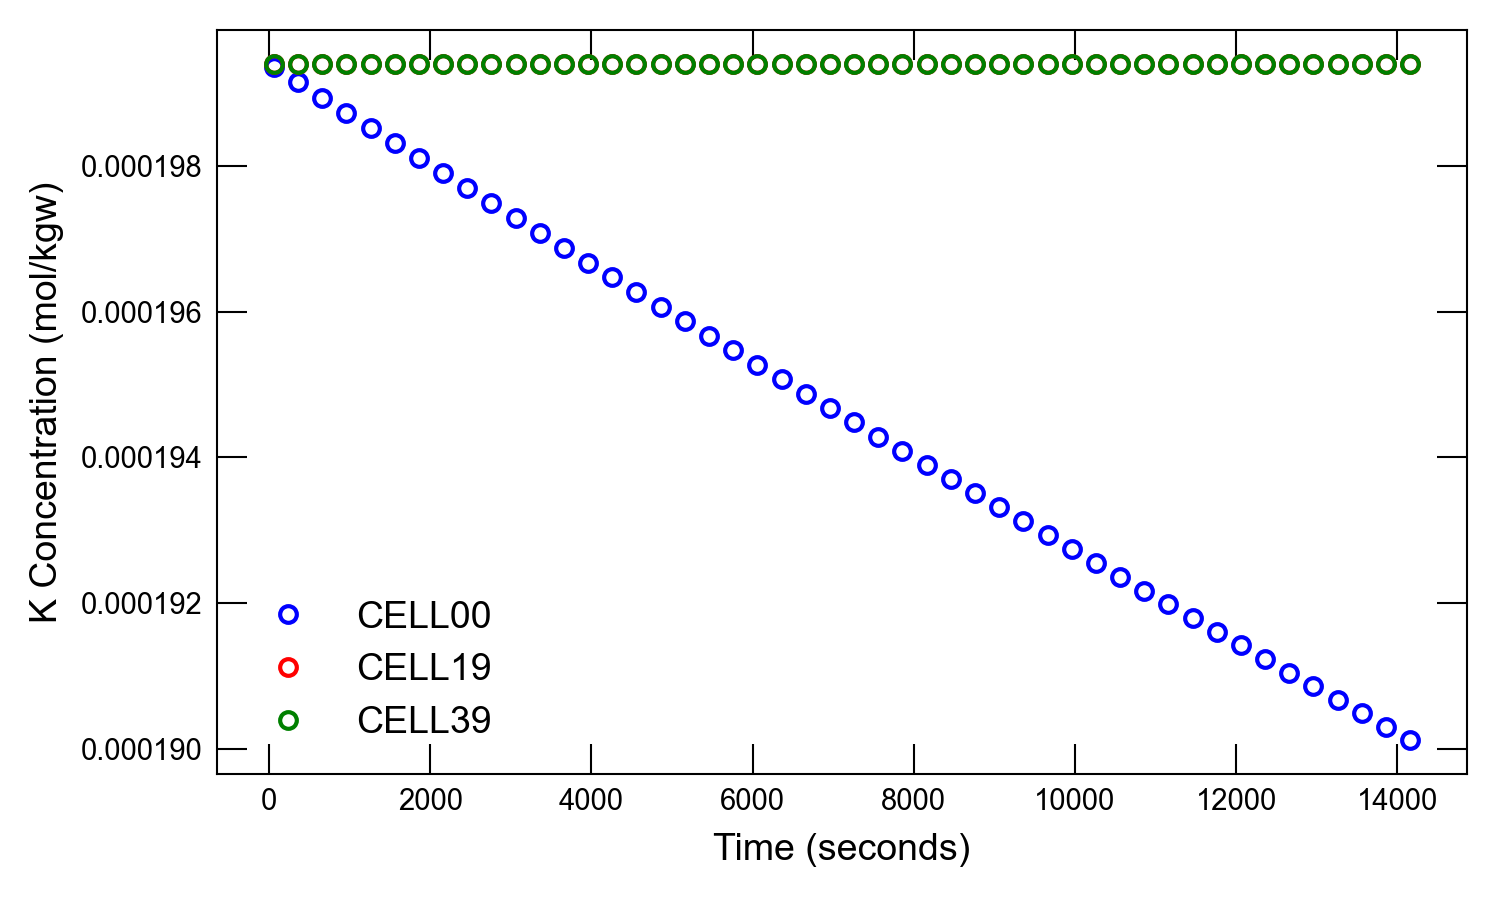

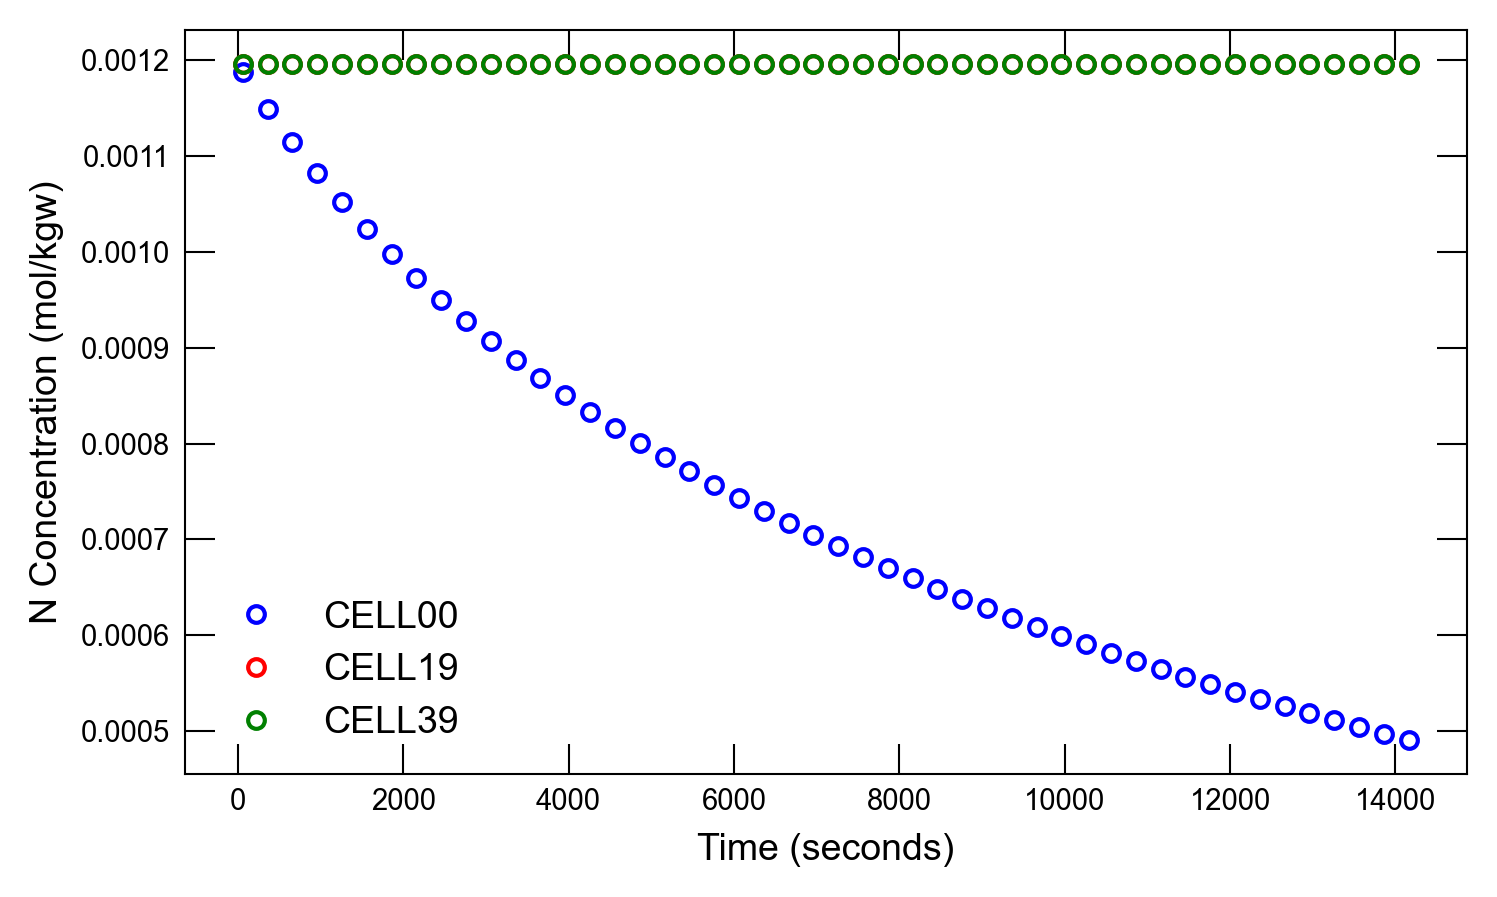

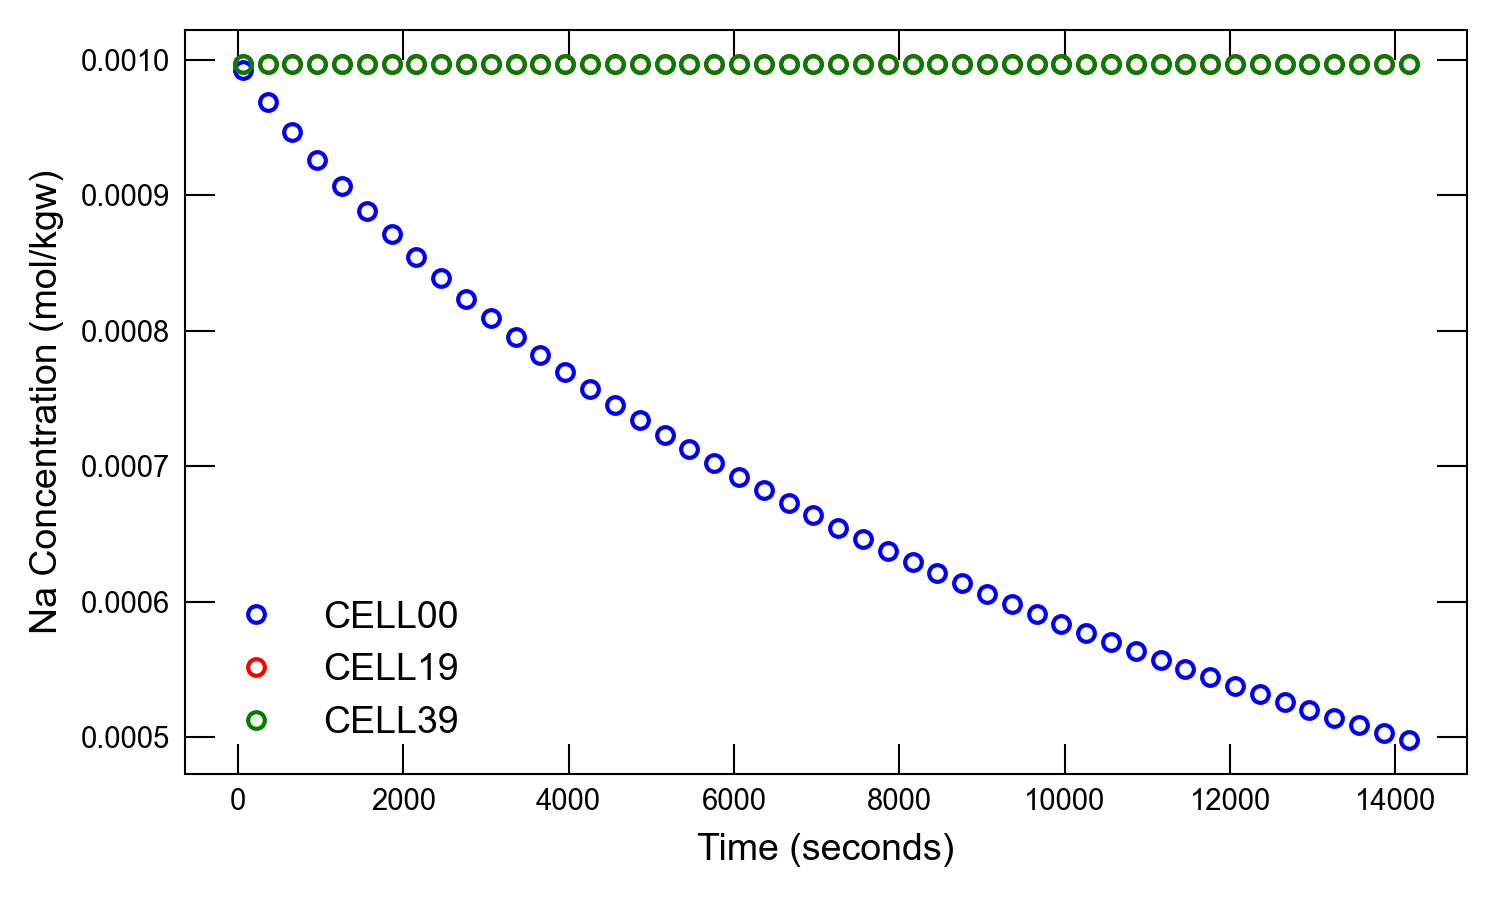

In [29]:
if __name__ == "__main__":
    scenario(0)